In [1]:
from py_files import get_crew_from_api
crew_df = get_crew_from_api.main()

Pulled crew data from Pixel Starships API.
Wrote data to excel file.
Wrote data to Wordpress db.
Here's your data frame!


In [2]:
from py_files import get_manual_grades
grades_df = get_manual_grades.main()

retrieved manual grades from wordpress


In [3]:
from py_files import prep_model_features
feats_df = prep_model_features.main(crew_df)

Normalizing crews' ability scores...
Creating binary category variables...
Scaling numeric variables...
Ready for modeling!


In [4]:
from py_files import create_model_sets
train_features, train_labels, test_features, test_labels = create_model_sets.main(feats_df, grades_df, 'Gunner')

Matching up grades with crew...
Removing ungraded crew...
The size of the model-able data is:
(354, 40)
Randomly selecting data sets...
We will use 283 training points and 70 test points.


# Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np

# linear regression model
Regmodel = LinearRegression()
Regmodel.fit(train_features, train_labels)

print("The linear regression model achieves an R2 value of " + str(Regmodel.score(test_features, test_labels)))

y_pred = Regmodel.predict(test_features)
print("At worst, the predicted score was off by " + str(round(np.max(y_pred - test_labels),3)) + " grades.\n")

The linear regression model achieves an R2 value of 0.894102823195
At worst, the predicted score was off by 1.461 grades.



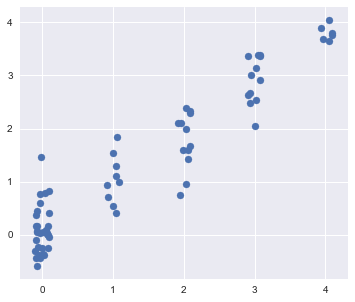

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred)

In [7]:
# what are the most important features?
coefs = Regmodel.coef_
top_feat_inds = np.fliplr([np.argsort(coefs)[-7:]])[0]
bottom_feat_inds = np.argsort(coefs)[0:7]

# features that bring rating up
for i in top_feat_inds:
    print("The feature " + feats_df.columns.tolist()[i+1] +   # one label later, since we dropped CrewId after model_data
          " has a coefficient of " +  str(coefs[i]))
print("\n")
# features that bring rating down
for i in bottom_feat_inds:
    print("The feature " + feats_df.columns.tolist()[i+1] + 
          " has a coefficient of " +  str(coefs[i]))

The feature FinalWeapon has a coefficient of 1.06646867841
The feature AddReload has a coefficient of 0.636098671713
The feature HealSameRoomCharacters has a coefficient of 0.420238734029
The feature FinalHp has a coefficient of 0.384294256721
The feature Freeze has a coefficient of 0.321906031185
The feature Common has a coefficient of 0.268241087586
The feature DamageToSameRoomCharacters has a coefficient of 0.228919706001


The feature FireWalk has a coefficient of -1.63934736456
The feature SetFire has a coefficient of -0.292167275314
The feature Unique has a coefficient of -0.225044442636
The feature Robot has a coefficient of -0.121903409153
The feature None has a coefficient of -0.0942736511058
The feature FinalAttack has a coefficient of -0.0877365987198
The feature TrainingCapacity has a coefficient of -0.0824949238584


# kNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1,3,5,7,9]

for k in k_values:  
    
    kNN = KNeighborsClassifier(n_neighbors = k)
    kNN.fit(train_features, train_labels)
    
    # take a stab at the test set
    y_pred = kNN.predict(test_features)
    # accuracy
    acc = round(sum(y_pred == test_labels)/test_labels.shape[0],3)*100
    
    # what if you consider +/- 1 star to be still "accurate"?
    acc2 = round((
        sum(y_pred == test_labels) + 
        sum(y_pred == test_labels-1) + sum(y_pred == test_labels+1)
        )/test_labels.shape[0],3)*100
    print("The kNN classifier with k=" + str(k) + " had an accuracy of " 
          + str(acc) + "% (and a +/-1 grade accuracy of " + str(acc2) + "%)." )

The kNN classifier with k=1 had an accuracy of 72.9% (and a +/-1 grade accuracy of 95.7%).
The kNN classifier with k=3 had an accuracy of 65.7% (and a +/-1 grade accuracy of 90.0%).
The kNN classifier with k=5 had an accuracy of 71.4% (and a +/-1 grade accuracy of 92.9%).
The kNN classifier with k=7 had an accuracy of 68.6% (and a +/-1 grade accuracy of 91.4%).
The kNN classifier with k=9 had an accuracy of 65.7% (and a +/-1 grade accuracy of 91.4%).


In [25]:
# use the best model: n = 1
kNN = KNeighborsClassifier(n_neighbors = 1)
kNN.fit(train_features, train_labels)

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = kNN.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")
print(str(errors) + "-- actual values")


The ratings misclassified by the classifier were: 
[3 0 2 3 1 4 1 2 2 2 2 0 0 3 4 2 1 2 3]-- predicted values
[2 1 1 2 2 2 0 0 3 1 3 1 1 2 3 4 2 3 2]-- actual values


'0.728571428571'

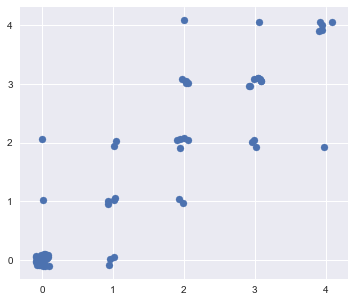

In [10]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

# Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# logistic regression model
LogRegmodel = LogisticRegression(multi_class = 'multinomial', solver='newton-cg')
LogRegmodel.fit(train_features, train_labels)

print("The logistic regression model achieves an R2 value of " + str(LogRegmodel.score(test_features, test_labels)))

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = LogRegmodel.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")
print(str(errors) + "-- actual values")

The logistic regression model achieves an R2 value of 0.714285714286

The ratings misclassified by the classifier were: 
[2 1 0 3 1 2 2 1 1 2 2 2 0 1 3 3 1 2 1 1]-- predicted values
[1 2 1 2 2 3 0 0 3 3 1 1 1 2 2 4 2 3 0 2]-- actual values


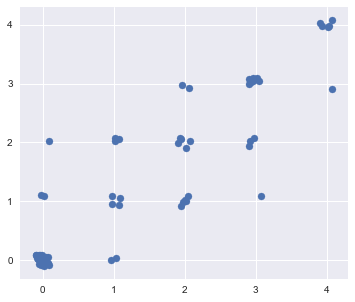

In [14]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

# Perceptron

In [22]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron()
perceptron.fit(train_features, train_labels)

print("The perceptron model achieves an R2 value of " + str(perceptron.score(test_features, test_labels)))
y_pred = perceptron.predict(test_features)

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = perceptron.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")
print(str(errors) + "-- actual values")

The perceptron model achieves an R2 value of 0.671428571429

The ratings misclassified by the classifier were: 
[3 2 3 2 2 2 2 2 2 2 2 2 0 3 2 2 1 4 2 2 4 2 1]-- predicted values
[2 0 2 3 3 0 0 0 3 3 1 1 1 2 3 4 2 0 3 3 3 0 2]-- actual values


C:\Users\Krissy\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


# SVM

In [24]:
from sklearn.svm import SVC
svc = SVC(kernel='poly', degree=8)
svc.fit(train_features, train_labels)

print("The svm model achieves an R2 value of " + str(svc.score(test_features, test_labels)))
y_pred = svc.predict(test_features)

The svm model achieves an R2 value of 0.442857142857


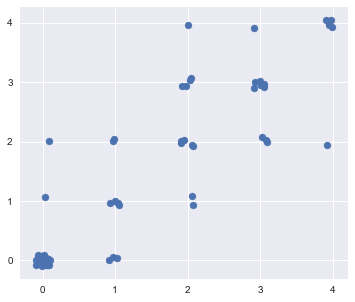

In [26]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

 # Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(train_features, train_labels)

print("The decision tree achieves an R2 value of " + str(tree.score(test_features, test_labels)))
y_pred = tree.predict(test_features)

The decision tree achieves an R2 value of 0.757142857143


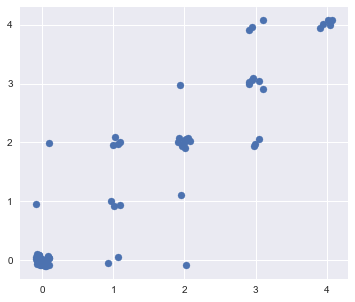

In [30]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)